# CelebA

Notebook to compare models for face attribute classification (CelebA).

Use `scripts/simulate_examples.py` to visualize embeddings and learned PSFs.

In [1]:
import numpy as np
import pathlib as plib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from lenslessclass.models import MultiClassLogistic, SLMClassifier, SingleHidden
from lenslessclass.datasets import Augmented
from lenslessclass.model_dict import model_dict
import json
from pprint import pprint
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from waveprop.devices import slm_dict, sensor_dict
import torchvision.datasets as dset
import os
import matplotlib
import random


font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)
linewidth = 3
markersize = 200


MODEL_DIR = "../models/celeba"


markers_dict = {
    "Lens": "o",
    "Coded aperture": "s",
    "Diffuser": "X",
    "Fixed mask (m)": "^",
    "Fixed mask (s)": "v",
    "Learned mask": "D",
}
color_dict = {
    "Lens": "darkorange",
    "Coded aperture": "red",
    "Diffuser": "deeppink",
    "Fixed mask (m)": "purple",
    "Fixed mask (s)": "blue",
    "Learned mask": "g",
}

markers = ["o", "s", "D", "P", "X", "v",  "<", ">", "D", ".", "1", "2", "3", "4", "8"]
linestyles = ["solid", "dotted", "dashed", "dashdot", (0, (3, 1, 1, 1, 1, 1))]



# accuracy curves

24x32 - best accuracy in 50 epochs : 0.893
3x4 - best accuracy in 50 epochs : 0.569


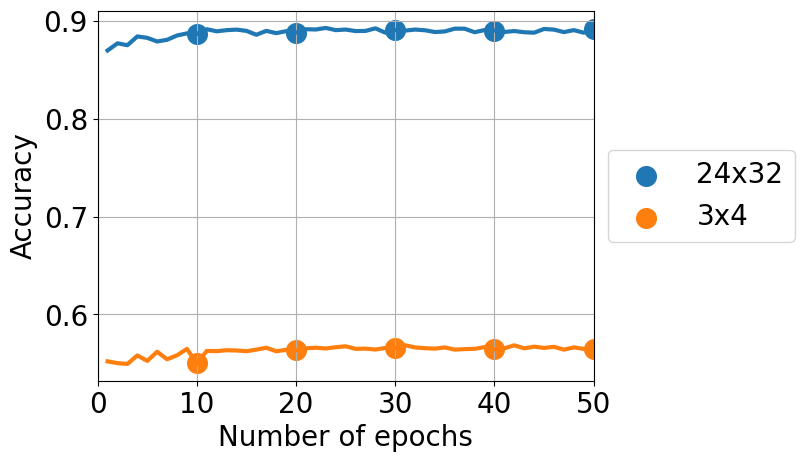

In [2]:
MAX_EPOCH = 50
plot_train = False
every = 10

# pick task
task = "Smiling"
# task = "Gender"
models = model_dict[task]

cam_filt = None
cam_filt = ["Lens"]
arch_filt = None
arch_filt = ["FCNN"]
dim_filt = None
dim_filt = ["3x4", "24x32"]
# dim_filt = ["24x32_multi"]


ax = plt.subplot(111)
for cam in models.keys():
    if cam_filt is not None and cam not in cam_filt:
        continue
    for arch in models[cam].keys():
        if arch_filt is not None and arch not in arch_filt:
            continue
        for dim in models[cam][arch].keys():
            if dim_filt is not None and dim not in dim_filt:
                continue
            _label = []
            if cam_filt is None or len(cam_filt) > 1:
                _label += [cam]
            if arch_filt is None or len(arch_filt) > 1:
                _label += [arch]
            if dim_filt is None or len(dim_filt) > 1:
                _label += [dim]

            _label = ", ".join(_label)
            model_path = models[cam][arch][dim]

            if isinstance(model_path, dict):
                # dictionary of seeds
                for seed in model_path.keys():

                    seed_path = MODEL_DIR / plib.Path(model_path[seed])

                    test_acc_fp = str(seed_path / "test_acc.npy")
                    _label = f"{cam}, {arch}, {dim}, {seed}"
                    if os.path.exists(test_acc_fp):
                        test_acc = np.load(test_acc_fp)
                        n_epoch = np.arange(len(test_acc)) + 1
                        print(f"{_label} - best accuracy in {len(n_epoch)} epochs : {round(np.max(test_acc), 3)}")
                        line,  = plt.plot(n_epoch,  test_acc, label=_label)
                    else:
                        print(f"{_label} - {test_acc_fp} does not exist") 
                    
                    if plot_train:
                        train_acc_fp = str(seed_path / "train_acc.npy")
                        train_acc = np.load(train_acc_fp)
                        n_epoch = np.arange(len(train_acc)) + 1
                        print(f"{_label} - best *train* accuracy in {len(n_epoch)} epochs : {round(np.max(train_acc), 3)}")
                        plt.plot(n_epoch, train_acc, c=line.get_color(), label=_label, marker="x")
            
            else:

                model_path = MODEL_DIR / plib.Path(model_path)
            
                test_acc_fp = str(model_path / "test_acc.npy")
                if os.path.exists(test_acc_fp):
                    test_acc = np.load(test_acc_fp)
                    n_epoch = np.arange(len(test_acc)) + 1
                    print(f"{_label} - best accuracy in {min(MAX_EPOCH, len(test_acc))} epochs : {round(np.max(test_acc[:MAX_EPOCH]), 3)}")
                    line, = plt.plot(n_epoch,  test_acc, linewidth=linewidth, linestyle="-")
                    ax.scatter(n_epoch[every-1::every], test_acc[every-1::every], marker=markers_dict[cam], s=markersize, c=line.get_color(), label=_label)
                else:
                    print(f"{_label} - {test_acc_fp} does not exist")

                if plot_train:
                    train_acc_fp = str(model_path / "train_acc.npy")
                    if os.path.exists(train_acc_fp):
                        train_acc = np.load(train_acc_fp)
                        n_epoch = np.arange(len(train_acc)) + 1
                        print(f"{_label} - best *train* accuracy in {min(MAX_EPOCH, len(test_acc))} epochs : {round(np.max(train_acc[:MAX_EPOCH]), 3)}")
                        plt.plot(n_epoch,  train_acc, c=line.get_color(), label=_label + ", train", linestyle="--", linewidth=linewidth)
            
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("Accuracy")
plt.xlabel("Number of epochs")
plt.xlim([0, MAX_EPOCH]);
plt.grid()

if len(arch_filt) == 1 and len(dim_filt) == 1:
    fp = f"{task}_{arch_filt[0]}_{dim_filt[0]}.png"
    plt.savefig(fp, bbox_inches='tight')
    print("Saved plot to : ", fp)

# loss curves

Learned mask, FCNN, 24x32 - best loss in 50 epochs : 0.278
Learned mask, FCNN, 24x32 - best *train* loss in 50 epochs : 0.287


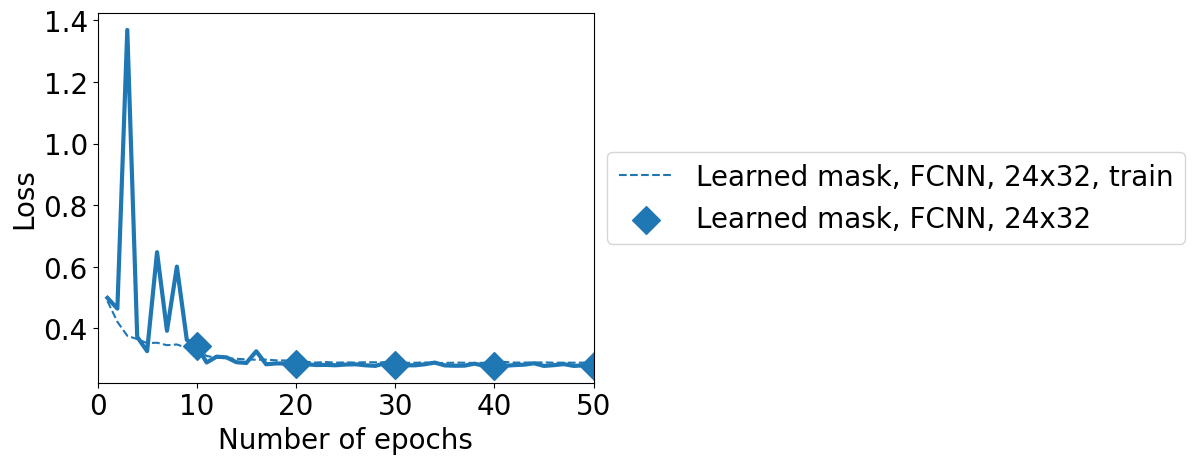

In [3]:
MAX_EPOCH = 50
every = 10
plot_train = True

# plot loss
cam_filt = None
cam_filt = ["Learned mask"]
arch_filt = None
arch_filt = ["FCNN"]
dim_filt = None
dim_filt = ["24x32"]

ax = plt.subplot(111)
for cam in models.keys():
    if cam_filt is not None:
        if cam not in cam_filt:
            continue
    for arch in models[cam].keys():
        if arch_filt is not None:
            if arch not in arch_filt:
                continue
        for dim in models[cam][arch].keys():
            if dim_filt is not None:
                if dim not in dim_filt:
                    continue
            _label = f"{cam}, {arch}, {dim}"
            model_path = models[cam][arch][dim]
            model_path = MODEL_DIR / plib.Path(model_path)

            test_loss_fp = str(plib.Path(model_path) / "test_loss.npy")
            if os.path.exists(test_loss_fp):
                test_loss = np.load(test_loss_fp)
                n_epoch = np.arange(len(test_loss)) + 1
                # line, = plt.plot(n_epoch,  test_loss, label=_label)
                print(f"{_label} - best loss in {min(MAX_EPOCH, len(test_loss))} epochs : {round(np.min(test_loss[:MAX_EPOCH]), 3)}")
                line, = plt.plot(n_epoch,  test_loss, linewidth=linewidth, linestyle="-")
                ax.scatter(n_epoch[every-1::every], test_loss[every-1::every], marker=markers_dict[cam], s=markersize, c=line.get_color(), label=_label)
            else:
                print(f"{_label} - {test_loss_fp} does not exist")

            if plot_train:
                train_loss_fp = str(plib.Path(model_path) / "train_loss.npy")
                if os.path.exists(train_loss_fp):
                    train_loss = np.load(train_loss_fp)
                    n_epoch = np.arange(len(train_loss)) + 1
                    # plt.plot(n_epoch,  train_loss, c=line.get_color(), label=_label + ", train", linestyle="--")
                    print(f"{_label} - best *train* loss in {min(MAX_EPOCH, len(train_loss))} epochs : {round(np.min(train_loss[:MAX_EPOCH]), 3)}")
                    plt.plot(n_epoch,  train_loss, c=line.get_color(), label=_label + ", train", linestyle="--")
                else:
                    print(f"{_label} - {train_loss_fp} does not exist")
           
plt.ylabel("Loss")
plt.xlabel("Number of epochs")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim([0, MAX_EPOCH]);
            

# performance drops

In [4]:
# pick task
task = "Smiling"
# task = "Gender"
models = model_dict[task]

# compute performance drop from lower resolution
for cam in models.keys():
    for arch in models[cam].keys():
        _model_dict = models[cam][arch]
        fp1 = str(MODEL_DIR / plib.Path(_model_dict["24x32"]) / "test_acc.npy")
        fp2 = str(MODEL_DIR / plib.Path(_model_dict["3x4"]) / "test_acc.npy")
        if os.path.exists(fp1) and os.path.exists(fp2):
            val1 = np.max(np.load(fp1))
            val2 = np.max(np.load(fp2))
            drop = 1. - val2 / val1
            print(f"{cam}, {arch} : {round(drop, 3) * 100}")

Lens, FCNN : 36.3
Coded aperture, FCNN : 33.4
Diffuser, FCNN : 28.7
Fixed mask (m), FCNN : 27.6
Fixed mask (s), FCNN : 28.000000000000004
Learned mask, FCNN : 14.000000000000002


# confusion matrix

In [5]:
DATA_DIR = "../data"  # to overwrite parent directory in metadata of model


task = "Smiling"
# task = "Gender"
models = model_dict[task]


model_dir = MODEL_DIR / plib.Path(models["Learned mask"]["FCNN"]["24x32"])
# model_dir = MODEL_DIR / plib.Path(models["Fixed mask (s)"]["FCNN"]["24x32"])

f = open(str(model_dir / "metadata.json"))
metadata = json.load(f)
# pprint(metadata)

In [6]:
n_class = 1

torch.manual_seed(metadata["seed"])
random.seed(metadata["seed"])
np.random.seed(metadata["seed"])

# load model
use_cuda = torch.cuda.is_available()
if use_cuda:
    print("CUDA available, using GPU.")
    device = "cuda"
else:
    device = "cpu"
    print("CUDA not available, using CPU.")


if "SLM" in metadata["model"]:

    sensor_act_fn = None
    sensor_act = metadata["sensor_activation"]
    if sensor_act is not None:
        if sensor_act == "relu":
            sensor_act_fn = nn.ReLU()
        elif sensor_act == "leaky":
            sensor_act_fn = nn.LeakyReLU(float=0.1)
        elif sensor_act == "tanh":
            sensor_act_fn = nn.Tanh()
        else:
            raise ValueError("Not supported activation.")

    metadata["model_param"].update(
        {
            "slm_config": slm_dict[metadata["slm"]],
            "sensor_config": sensor_dict[metadata["sensor"]],
            "sensor_activation": sensor_act_fn,
            "n_class": n_class,
            "multi_gpu": [0, 1] if metadata["model_param"]["multi_gpu"] else False,
        }
    )
    model = SLMClassifier(**metadata["model_param"])
    if use_cuda:
        model = model.to(device)

    # -- load from state dict
    state_dict_fp = str(model_dir / "state_dict.pth")
    model.load_state_dict(torch.load(state_dict_fp))

    # recompute PSF for loaded SLM values
    model.grayscale = True
    model.compute_intensity_psf()

    device = model.device

else:

    if metadata["hidden_dim"]:
        model = SingleHidden(
            input_shape=metadata["output_dim"],
            hidden_dim=metadata["hidden_dim"][0],
            n_class=n_class,
        )

    else:
        model = MultiClassLogistic(input_shape=metadata["output_dim"], n_class=n_class)

    if metadata["model_param"]["multi_gpu"]:
        model = nn.DataParallel(model, device_ids=metadata["model_param"]["multi_gpu"])
        device = "cuda:" + str(int(metadata["model_param"]["multi_gpu"][0]))

    if use_cuda:
        model = model.to(device)

    # -- load from state dict
    state_dict_fp = str(model_dir / "state_dict.pth")
    model.load_state_dict(torch.load(state_dict_fp))


CUDA available, using GPU.


In [7]:
print("\nModel's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


Model's state_dict:
slm_vals 	 torch.Size([51, 22])
linear1.module.weight 	 torch.Size([800, 768])
bn.module.weight 	 torch.Size([800])
bn.module.bias 	 torch.Size([800])
bn.module.running_mean 	 torch.Size([800])
bn.module.running_var 	 torch.Size([800])
bn.module.num_batches_tracked 	 torch.Size([])
linear2.module.weight 	 torch.Size([1, 800])
linear2.module.bias 	 torch.Size([1])
conv_bn.module.weight 	 torch.Size([1])
conv_bn.module.bias 	 torch.Size([1])
conv_bn.module.running_mean 	 torch.Size([1])
conv_bn.module.running_var 	 torch.Size([1])
conv_bn.module.num_batches_tracked 	 torch.Size([])


In [8]:
from lenslessclass.datasets import CelebAAugmented, CELEBA_ATTR
from torch.utils.data import Subset

_path = metadata["dataset"]
print(_path)

# load test set
try:    
    test_indices = np.load(model_dir / "test_indices.npy")
except: 
    # old model which didn't have test indices saved
    print("using learned test indices, should be same...")
    test_indices = np.load("../celeba_no_psf_down8_height0.27_NORM_100000files_scene2mask0.55_outdim768_Smiling_50epoch_seed0_SLM_SingleHidden800_poisson40.0_22102022_07h16/test_indices.npy")

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize(metadata["mean"], metadata["std"])])
all_data = CelebAAugmented(
    path=_path, 
    transform=trans,
)
test_set = Subset(all_data, test_indices)
print(len(test_set))

test_loader = torch.utils.data.DataLoader(
    dataset=test_set, batch_size=400, shuffle=False
)


label_idx = CELEBA_ATTR.index(metadata["attr"])

/scratch/LenslessClassification_data/celeba/celeba_no_psf_down8_height0.27_NORM_100000files
15000


In [9]:
# compute accuracy
criterion = nn.CrossEntropyLoss().to(device)

y_pred = []
y_true = []
correct_cnt, running_loss = 0, 0
total_cnt = 0

model.eval()
with torch.no_grad():
    for x, target in test_loader:

        # get inputs
        if use_cuda:
            x, target = x.to(device=device), target.to(device=device)

        target = target[:, label_idx]
        target = target.unsqueeze(1)
        target = target.to(x)

        if "min_val" in metadata.keys():
            x -= metadata["min_val"]

        # forward, and compute loss
        out = model(x).to(device=device)
        loss = criterion(out, target)

        pred_label = out.round()
        pred_label = pred_label.to(device=device)
        correct_cnt += (pred_label == target).sum()
        total_cnt += x.data.size()[0]

        # save prediction and true for confusion matrix
        y_pred.extend(pred_label.data.cpu().numpy().squeeze()) # Save Prediction
        y_true.extend(target.data.cpu().numpy().squeeze())

acc = (correct_cnt * 1.0 / total_cnt).item()
print("acc: {:.3f}".format(acc))
print('Class distribution: %s' % np.bincount(y_true))

/home/bezzam/LenslessClassification/lenslessclass/models.py:758: UserWarning: Got negative data. Shift to non-negative.
  warnings.warn("Got negative data. Shift to non-negative.")


acc: 0.883
Class distribution: [7823 7177]


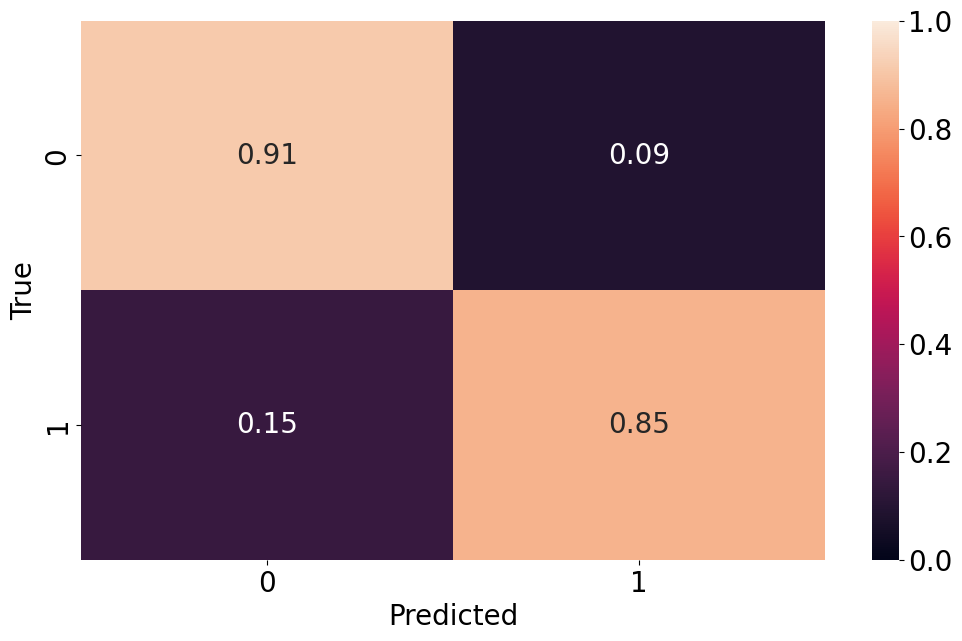

In [10]:
# Build confusion matrix
classes = np.arange(2)
cf_matrix = confusion_matrix(y_true, y_pred, normalize="true")

plt.figure(figsize = (12,7))
sn.heatmap(cf_matrix, annot=True, fmt=".2f", vmin=0, vmax=1)
plt.ylabel("True")
plt.xlabel("Predicted");